## Code adapted from https://keras.io/examples/nlp/lstm_seq2seq/

Load the necessary packages and mount our drive:

In [1]:
import os
import numpy as np
from os import listdir
from pathlib import Path
from re import sub, search
from itertools import product
from random import choice, shuffle
from IPython.display import clear_output

import keras
from tensorflow.keras import backend

from matplotlib.pyplot import plot, legend, show, xlabel, ylabel, title


Hyperparameters:

In [2]:
batch_size = 32  #Batch size for training
epochs = 100  #Number of epochs to train for
latent_dim = 32  #Latent dimensionality of the encoding space.
lr = 0.0005 #Learning rate
reps = 10 #Repetitions in each condition
attention = False #Do you want attention in your model?
stim_sets = ["equalFreq"] #Need a training file for each stim_set
test_sets = ["test_Mutants", "testNewTemplates", "test_L", "test"] #Need a file for each of these test sets for each stim_set

Feature systems:

In [5]:
#inputs
feat_file = open("feats.txt", "r")
feat_names = feat_file.readline().rstrip().split("\t")[1:] # Skip first space
symbol2feats_ur = {'_': [0.0 for f in feat_names]}

for line in feat_file.readlines():
  columns = line.rstrip().split("\t")
  seg = columns[0]
  values = [{"-":-1.0, "+":1.0, "0":0.0}[v] for v in columns[1:]]
  symbol2feats_ur[seg] = values

#outputs
feats2symbol_sr = {
                      "1,1":"Y IY0", #yee
                      "1,-1":"W AH0", #wuh
                      "-1,1":"L EY0", #lay
                      "-1,-1":"?"
                  }

print(feat_names)
print(len(feat_names))

#Note that with:
# latent_dim = 32
# len(symbol2feats_ur.keys()) = 15
# Number of parameters with attention = 10754
# Number of parameters without attention = 10690

['cons', 'syll', 'son', 'approx', 'voice', 'cont', 'nas', 'strid', 'lab', 'cor', 'ant', 'dist', 'dor', 'high', 'back', 'tense', 'diph', 'stress', 'main']
19


Functions for processing data and building model:

In [11]:
def get_strings(input_fn):
  input_file = open("./Equal_FrequencyCondition/"+input_fn)
  input_file.readline()
  UR_strings = []
  SR_strings = []
  syll_lengths = []
  ur_num = 0

  for line in input_file.readlines():
    columns = line.rstrip().split(",")
    if len(columns) == 2:
      ur, sr = columns
      if sr == "" or ur == "":
        continue
      ur_num += 1

      syll_lengths.append(len([seg for seg in ur.split(" ") if seg != ""]))
      UR_strings.append(ur)
      SR_strings.append(sr[-5:]) # Last 5 characters correspond to plural suffix
    else:
       print(line)
       raise Exception("Training data error! All lines should have 2 columns in TD files!")

  return UR_strings, SR_strings, syll_lengths

def get_arrays(UR_strings, SR_strings, syll_lengths):
  symbol2feats_sr = {}
  for feat_bundle in feats2symbol_sr.keys():
    these_feats = [float(f) for f in feat_bundle.split(",")] # [1.0, -1.0]
    symbol2feats_sr[feats2symbol_sr[feat_bundle]] = these_feats # Maps "Y IY0" -> [1.0, 1.0]

  max_len = max(syll_lengths)
  X_list = []
  Y_list = []
  padding_strs = []
  for word_index, syll_length in enumerate(syll_lengths):
    padding = " ".join(["_"]*(max_len-syll_length))
    this_ur = UR_strings[word_index]+" "+padding # Singular form + padding as string
    padding_strs.append(this_ur)
    this_sr = SR_strings[word_index][-5:] # Suffix as string

    #Fix some errors in data files:
    this_ur = sub(" J ", " Y ", this_ur)
    this_ur = sub(" C ", " CH ", this_ur)

    X_list.append([symbol2feats_ur[seg] for seg in this_ur.split(" ") if seg != ""])
    #X_list.append([symbol2feats_ur[sub("\d", "", seg)] for seg in this_ur.split(" ") if seg != ""])
    Y_list.append([symbol2feats_sr[this_sr]])

  X = np.array(X_list)
  Y = np.array(Y_list)

  print(f"The shape of X is: {X.shape}")
  print(f"The shape of Y is: {Y.shape}")

  return X, Y

def get_accuracies(corr_out, pred_out):
  accs_by_word = []
  for corr_word, pred_word in zip(corr_out, pred_out):
    this_acc = 1.0
    for corr_seg, pred_seg in zip(corr_word, pred_word):
      for corr_feat, pred_feat in zip(corr_seg, pred_seg):
        if corr_feat < 0.0 and (pred_feat >= 0.0):
          this_acc = 0.0
          break
        elif corr_feat > 0.0 and pred_feat <= 0.0:
          this_acc = 0.0
          break
      if this_acc == 0.0:
        break
    accs_by_word.append(this_acc)
  return accs_by_word

def get_test_results (test_preds):
    results = []
    for word in test_preds:
      for seg in word:
        feat_list = []
        for feat in seg:
          if feat < 0.0:
            feat_list.append("-1")
          elif feat > 0.0:
            feat_list.append("1")
          else:
            raise Exception()
      feat_string = ",".join(feat_list)
      suff = feats2symbol_sr[feat_string]
      results.append(suff)
    return results

def get_model(use_att=False):
  num_encoder_features = len(list(symbol2feats_ur.values())[0]) # 19
  num_decoder_features = len(list(feats2symbol_sr.keys())[0].split(",")) # 2

  # Define an input sequence and process it.
  encoder_inputs = keras.Input(shape=(None, num_encoder_features))
  encoder = keras.layers.LSTM(latent_dim, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs)

  # We discard `encoder_outputs` and only keep the states.
  encoder_states = [state_h, state_c]

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = keras.Input(shape=(None, num_decoder_features))

  # We set up our decoder to return full output sequences,
  # and to return internal states as well. We don't use the
  # return states in the training model, but we will use them in inference.
  decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  decoder_dense = keras.layers.Dense(num_decoder_features, activation="tanh")

  if use_att: #Are we including attention in our model?
    attention = keras.layers.Attention()
    attention_outputs = attention([decoder_outputs, encoder_outputs])

    concatenate = keras.layers.Concatenate(axis=-1)
    decoder_concat_input = concatenate([decoder_outputs, attention_outputs])
    decoder_outputs = decoder_dense(decoder_concat_input)
  else:
    decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  return model

Running the actual simulations (one for each repetition in each condition):

In [12]:
allLosses = []
allAccs = []
for my_set in stim_sets:
  #Load the training data:
  URs, SRs, Ls = get_strings(my_set+"_train.txt")
  X, Y = get_arrays(URs, SRs, Ls)

  for rep in range(reps):
    print("Rep: ", rep, ", Set:", my_set)

    #Build the model for this repetition:
    model = get_model(attention)

    my_opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(
        optimizer=my_opt, loss="mean_squared_error", metrics=["accuracy"]
    )
    decoder_data = np.zeros(
      (len(X), 1, len(list(feats2symbol_sr.keys())[0].split(","))),
      dtype="float32",
    )

    hist = model.fit(
        [X, decoder_data],
        Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.,
    )
    # Save model
    # model.save("/content/gdrive/My Drive/German-Plur-Sims/"+"Rep:"+str(rep)+",Set:"+my_set+",Attention:"+str(attention)+".keras")
    model.save("./LSTM_Run_Results/"+"Rep_"+str(rep)+"_Set_"+my_set+"_Attention_"+str(attention)+".keras")

    # Save the loss:
    allLosses.append(hist.history["loss"])
    allAccs.append(hist.history["accuracy"])


    # Clear away backend and output:
    backend.clear_session()
    clear_output()


The shape of X is: (1188, 5, 19)
The shape of Y is: (1188, 1, 2)
Rep:  0 , Set: equalFreq
Num encoder features: 19
Num decoder features: 2


Plot learning curves (averaged over all runs and conditions):

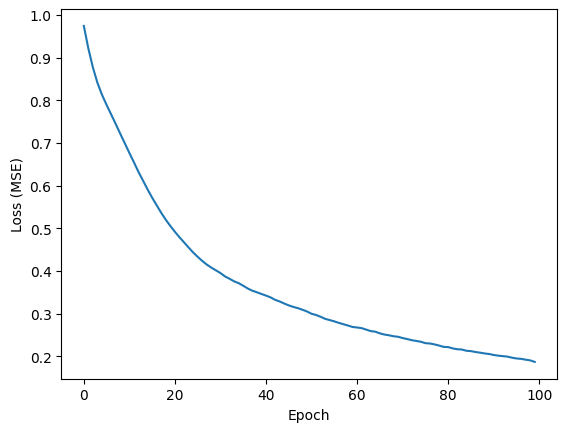

In [16]:
#Plot average loss (for checking lr, etc.)
av_curve = np.mean(allLosses, axis=0)
plot(av_curve)
xlabel("Epoch")
ylabel("Loss (MSE)")
show()

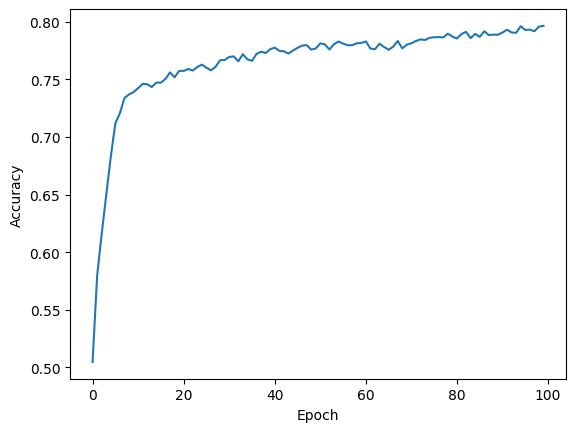

In [17]:
#Plot average accuracy on training (for checking lr, etc.)
av_curve = np.mean(allAccs, axis=0)
plot(av_curve)
xlabel("Epoch")
ylabel("Accuracy")
show()

Load models and test them:

In [19]:
output_file = open("./LSTM_Run_Results/minDef_output.csv", "w")
output_file.write("Set,TestSet,Rep,Input,CorrOutput,PredOutput\n")
for my_set in stim_sets:
  print(my_set)

  for ts in test_sets:
    print("\t"+ts)

    #Load the testing data:
    test_URs, test_SRs, test_Ls = get_strings(my_set+"_"+ts+".txt")
    test_X, test_Y = get_arrays(test_URs, test_SRs, test_Ls)

    for rep in range(reps):
      print("\t\tRep: ", rep)

      #Load a previous model:
      model_name = "Rep_"+str(rep)+"_Set_"+my_set+"_Attention_"+str(attention)
      model = keras.models.load_model("./LSTM_Run_Results/"+model_name+".keras")
      decoder_data = np.zeros(
        (len(test_X), 1, len(list(feats2symbol_sr.keys())[0].split(","))),
        dtype="float32",
      )

      #Test the model:
      preds = get_test_results(model.predict([test_X, decoder_data]))

      #Record everything:
      for i, co, po in zip(test_URs, test_SRs, preds):
        output_file.write(",".join([my_set, ts, str(rep), i, co, po])+"\n")

      # Clear away backend and output:
      backend.clear_session()
      #clear_output()

output_file.close()

equalFreq
	test_Mutants
		Rep:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
		Rep:  1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
		Rep:  2
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x34d22c280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
		Rep:  3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
		Rep:  4
3/3 ━━━━━━━━━━━━━